In [24]:
import pandas as pd

candles = pd.read_csv("../data/nba_market_candles_sample.csv")

print(candles.head())
print(candles.tail())
print(candles.dtypes)


                     market_id          ts  yes_price  no_price  volume  \
0  KXNBAGAME-26JAN14WASLAC-LAC  1768320180       0.81      0.19       1   
1  KXNBAGAME-26JAN14WASLAC-LAC  1768321500        NaN       NaN       0   
2  KXNBAGAME-26JAN14WASLAC-LAC  1768321680        NaN       NaN       0   
3  KXNBAGAME-26JAN14WASLAC-LAC  1768321800        NaN       NaN       0   
4  KXNBAGAME-26JAN14WASLAC-LAC  1768321860        NaN       NaN       0   

  market_status  
0     finalized  
1     finalized  
2     finalized  
3     finalized  
4     finalized  
                           market_id          ts  yes_price  no_price  volume  \
2135839  KXNBAGAME-25APR15ATLORL-ORL  1744761360       0.75      0.25      15   
2135840  KXNBAGAME-25APR15ATLORL-ORL  1744761420       0.74      0.26      62   
2135841  KXNBAGAME-25APR15ATLORL-ORL  1744761480       0.75      0.25     625   
2135842  KXNBAGAME-25APR15ATLORL-ORL  1744761540       0.74      0.26      26   
2135843  KXNBAGAME-25APR15ATLORL-ORL

In [25]:
candles = candles.sort_values(["market_id", "ts"])

summary = (
    candles
    .groupby("market_id")
    .agg(
        n_candles=("ts", "count"),
        start_ts=("ts", "min"),
        end_ts=("ts", "max"),
        max_gap_sec=("ts", lambda x: x.diff().max())
    )
    .reset_index()
)

print(summary)


                        market_id  n_candles    start_ts      end_ts  \
0     KXNBAGAME-25APR15ATLORL-ATL        135  1744653660  1744761600   
1     KXNBAGAME-25APR15ATLORL-ORL        160  1744653660  1744761600   
2     KXNBAGAME-25APR15MEMGSW-GSW        113  1744653660  1744761600   
3     KXNBAGAME-25APR15MEMGSW-MEM         85  1744653660  1744761540   
4     KXNBAGAME-25APR16DALSAC-DAL        101  1744737780  1744847820   
...                           ...        ...         ...         ...   
1459  KXNBAGAME-26JAN14TORIND-TOR       1730  1768320000  1768435200   
1460  KXNBAGAME-26JAN14UTACHI-CHI       1506  1768320000  1768435200   
1461  KXNBAGAME-26JAN14UTACHI-UTA       1457  1768320180  1768435200   
1462  KXNBAGAME-26JAN14WASLAC-LAC       1697  1768320180  1768435200   
1463  KXNBAGAME-26JAN14WASLAC-WAS       1752  1768320000  1768435200   

      max_gap_sec  
0         29820.0  
1         25920.0  
2         33000.0  
3         28080.0  
4         20040.0  
...           .

In [26]:
candles["dt"] = candles.groupby("market_id")["ts"].diff()

print(candles["dt"].value_counts().head(10))


dt
60.0     1909125
120.0     122572
180.0      44584
240.0      20896
300.0      12165
360.0       6526
420.0       3946
480.0       2814
540.0       2034
600.0       1791
Name: count, dtype: int64


In [27]:
bad_prices = candles[
    (candles.yes_price < 0) |
    (candles.yes_price > 1) |
    (candles.no_price < 0) |
    (candles.no_price > 1)
]

print("Bad price rows:", len(bad_prices))


Bad price rows: 0


In [28]:
candles["sum_prices"] = candles.yes_price + candles.no_price
print(candles["sum_prices"].describe())


count    9.061810e+05
mean     1.000000e+00
std      2.209509e-17
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: sum_prices, dtype: float64


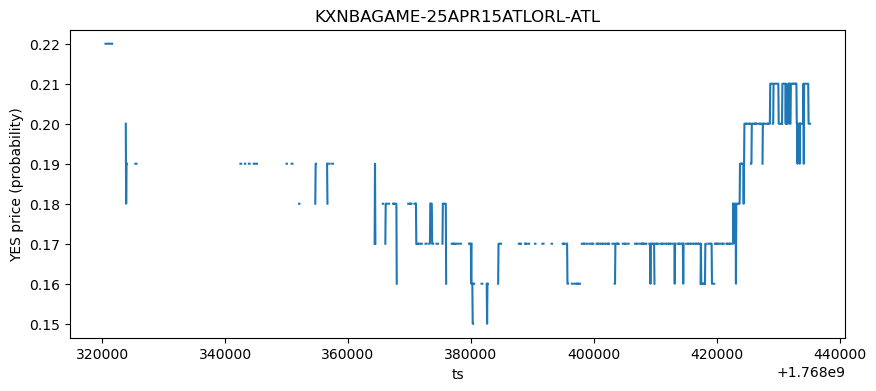

In [29]:
import matplotlib.pyplot as plt

example_market = candles.market_id.unique()[0]

df = candles[candles.market_id == 'KXNBAGAME-26JAN14WASLAC-WAS']

plt.figure(figsize=(10, 4))
plt.plot(df.ts, df.yes_price)
plt.title(example_market)
plt.xlabel("ts")
plt.ylabel("YES price (probability)")
plt.show()


In [30]:
import numpy as np
import pandas as pd

df = pd.read_csv("../data/nba_market_candles_features.csv")
df = df.sort_values(["market_id", "segment_id", "ts"]).reset_index(drop=True)

horizons = [3, 5, 10, 15]
thresholds = [0.03, 0.05, 0.07, 0.10]
group_cols = ["market_id", "segment_id"]

for H in horizons:
    future_max = (
        df.groupby(group_cols, sort=False)["p_filled"]
        .apply(lambda s: s.shift(-1).rolling(H, min_periods=H).max().shift(-(H - 1)))
        .reset_index(level=group_cols, drop=True)
    )
    df[f"future_max_move_{H}m"] = future_max - df["p_filled"]
    for d in thresholds:
        col = f"spike_up_{H}m_{int(d * 100)}pct"
        df[col] = np.where(
            df[f"future_max_move_{H}m"].notna(),
            (df[f"future_max_move_{H}m"] >= d).astype(int),
            np.nan,
        )

summary_rows = []
for H in horizons:
    for d in thresholds:
        col = f"spike_up_{H}m_{int(d * 100)}pct"
        total = int(df[col].notna().sum())
        spikes = int((df[col] == 1).sum())
        freq = (spikes / total * 100) if total else 0.0
        summary_rows.append(
            {"label": col, "total_rows": total, "spikes": spikes, "freq_pct": freq}
        )

summary_df = pd.DataFrame(summary_rows)
print(summary_df)


                 label  total_rows  spikes  freq_pct
0     spike_up_3m_3pct     1897875   13860  0.730290
1     spike_up_3m_5pct     1897875    5917  0.311770
2     spike_up_3m_7pct     1897875    3521  0.185523
3    spike_up_3m_10pct     1897875    1657  0.087308
4     spike_up_5m_3pct     1823285   19174  1.051618
5     spike_up_5m_5pct     1823285    8992  0.493176
6     spike_up_5m_7pct     1823285    5673  0.311142
7    spike_up_5m_10pct     1823285    2835  0.155489
8    spike_up_10m_3pct     1706607   27438  1.607752
9    spike_up_10m_5pct     1706607   14135  0.828252
10   spike_up_10m_7pct     1706607    9684  0.567442
11  spike_up_10m_10pct     1706607    5496  0.322043
12   spike_up_15m_3pct     1630841   32942  2.019939
13   spike_up_15m_5pct     1630841   17476  1.071594
14   spike_up_15m_7pct     1630841   12455  0.763716
15  spike_up_15m_10pct     1630841    7411  0.454428


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = df.copy()

features = ["ret_1", "ret_3", "ret_5", "vol_5", "vol_10", "vol_sum_5", "trade_active"]
plot_features = ["ret_5", "vol_10", "vol_sum_5"]
labels = ["spike_up_10m_5pct", "spike_up_10m_7pct"]

def summarize_feature(series: pd.Series) -> dict:
    return {
        "mean": series.mean(),
        "median": series.median(),
        "p25": series.quantile(0.25),
        "p75": series.quantile(0.75),
    }

def analyze_label(label: str) -> None:
    print("=" * 80)
    print(f"Label: {label}")
    sub = df[df[label].notna()].copy()
    pre = sub[sub[label] == 1]
    non = sub[sub[label] == 0]
    print(f"Rows used: {len(sub)} (pre-spike={len(pre)}, non-spike={len(non)})")

    summary_rows = []
    for feat in features:
        pre_stats = summarize_feature(pre[feat])
        non_stats = summarize_feature(non[feat])
        summary_rows.append(
            {
                "feature": feat,
                "pre_mean": pre_stats["mean"],
                "non_mean": non_stats["mean"],
                "diff_mean": pre_stats["mean"] - non_stats["mean"],
                "pre_median": pre_stats["median"],
                "non_median": non_stats["median"],
                "diff_median": pre_stats["median"] - non_stats["median"],
                "pre_p25": pre_stats["p25"],
                "pre_p75": pre_stats["p75"],
                "non_p25": non_stats["p25"],
                "non_p75": non_stats["p75"],
            }
        )

    summary_df = pd.DataFrame(summary_rows)
    print(summary_df)

    fig, axes = plt.subplots(1, len(plot_features), figsize=(16, 4))
    for ax, feat in zip(axes, plot_features):
        ax.hist(pre[feat].dropna(), bins=50, alpha=0.6, label="pre-spike", density=True)
        ax.hist(non[feat].dropna(), bins=50, alpha=0.6, label="non-spike", density=True)
        ax.set_title(feat)
        ax.legend()
    plt.tight_layout()
    plt.show()

for label in labels:
    analyze_label(label)

print("Summary (qualitative):")
print("- Check diff_mean/diff_median for largest separation by feature.")
print("- Compare p25/p75 to see if shifts are consistent or noisy.")
print("- Focus on features with stable separation across both labels.")


In [ ]:
import numpy as np
import pandas as pd

spike_label = "spike_up_10m_5pct"
H = 10
W = 30
cooldown_s = 15 * 60

df = df.sort_values(["market_id", "segment_id", "ts"]).reset_index(drop=True)

vol10_p90 = df["vol_10"].dropna().quantile(0.9)
volsum5_p90 = df["vol_sum_5"].dropna().quantile(0.9)

panic_regime = (
    (df["gap_flag"] == 0)
    & (df["p_filled"].notna())
    & (df["trade_active"] == 1)
    & (df["vol_10"] >= vol10_p90)
    & (df["vol_sum_5"] >= volsum5_p90)
)
df["panic_regime"] = panic_regime.astype(int)

events = []

for (market_id, segment_id), seg in df.groupby(["market_id", "segment_id"], sort=False):
    seg = seg.reset_index(drop=True)
    candidates = seg[(seg[spike_label] == 1) & (seg["panic_regime"] == 1)]

    last_event_ts = None
    for idx in candidates.index:
        t0_ts = seg.at[idx, "ts"]
        if last_event_ts is not None and t0_ts - last_event_ts < cooldown_s:
            continue

        window = seg.iloc[idx + 1 : idx + 1 + H]
        if len(window) < H:
            continue

        p0 = seg.at[idx, "p_filled"]
        peak_idx = window["p_filled"].idxmax()
        p_peak = seg.at[peak_idx, "p_filled"]
        t_peak_ts = seg.at[peak_idx, "ts"]
        S = p_peak - p0
        time_to_peak = t_peak_ts - t0_ts

        post_window = seg.iloc[peak_idx + 1 : peak_idx + 1 + W]

        post_rets = {}
        for k in [1, 3, 5, 10, 15, 30]:
            if peak_idx + k < len(seg):
                post_rets[f"post_ret_{k}"] = seg.at[peak_idx + k, "p_filled"] - p_peak
            else:
                post_rets[f"post_ret_{k}"] = np.nan

        time_to_revert_50 = np.nan
        if len(post_window) > 0 and S > 0:
            target = p_peak - 0.5 * S
            revert_rows = post_window[post_window["p_filled"] <= target]
            if not revert_rows.empty:
                time_to_revert_50 = revert_rows.iloc[0]["ts"] - t_peak_ts

        max_future = post_window["p_filled"].max() if len(post_window) > 0 else np.nan
        min_future = post_window["p_filled"].min() if len(post_window) > 0 else np.nan
        short_adverse = max_future - p_peak if pd.notna(max_future) else np.nan
        short_favorable = p_peak - min_future if pd.notna(min_future) else np.nan

        events.append(
            {
                "market_id": market_id,
                "segment_id": segment_id,
                "t0": t0_ts,
                "t_peak": t_peak_ts,
                "p0": p0,
                "p_peak": p_peak,
                "S": S,
                "time_to_peak": time_to_peak,
                "time_to_revert_50": time_to_revert_50,
                "max_future": max_future,
                "min_future": min_future,
                "short_adverse": short_adverse,
                "short_favorable": short_favorable,
                **post_rets,
            }
        )

        last_event_ts = t0_ts

events = pd.DataFrame(events)
print(f"Events found: {len(events)}")

summary_cols = [
    "S",
    "post_ret_5",
    "post_ret_10",
    "post_ret_30",
    "time_to_revert_50",
    "short_adverse",
    "short_favorable",
]

summary = []
for col in summary_cols:
    series = events[col].dropna()
    summary.append(
        {
            "metric": col,
            "count": int(series.count()),
            "mean": series.mean(),
            "median": series.median(),
            "p25": series.quantile(0.25),
            "p75": series.quantile(0.75),
        }
    )

summary_df = pd.DataFrame(summary)
print(summary_df)


Summary metrics
num_trades: 365
win_rate: 0.488
mean_pnl: -0.0096
median_pnl: -0.0100
pnl_p25: -0.0700
pnl_p75: 0.0400
mean_hold_minutes: 4.61
median_hold_minutes: 3.00
avg_MAE: 0.0345
median_MAE: 0.0200
avg_MFE: 0.0334
median_MFE: 0.0200
max_drawdown: -4.0200


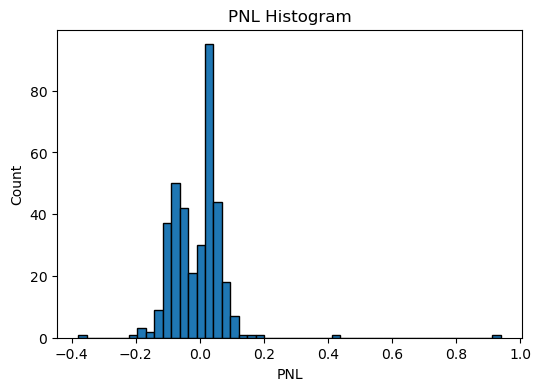

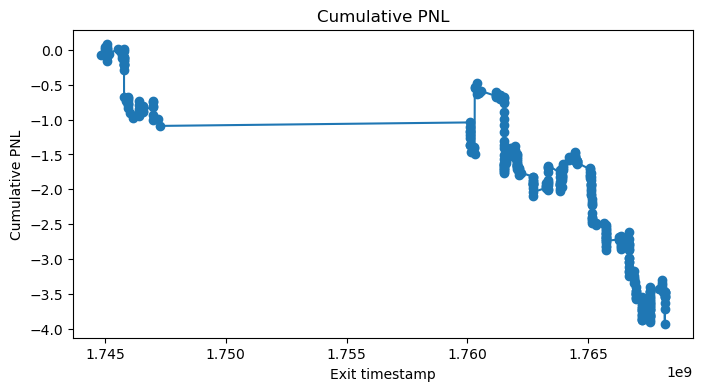

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = df.sort_values(["market_id", "segment_id", "ts"]).reset_index(drop=True)

# Global thresholds for panic regime
vol10_q90 = df["vol_10"].dropna().quantile(0.9)
volsum5_q90 = df["vol_sum_5"].dropna().quantile(0.9)

df["panic_regime"] = (
    (df["gap_flag"] == 0)
    & (df["p_filled"].notna())
    & (df["trade_active"] == 1)
    & (df["vol_10"] >= vol10_q90)
    & (df["vol_sum_5"] >= volsum5_q90)
)

df["panic_start"] = df["panic_regime"] & (df["ret_3"] >= 0.05)

trades = []
cooldown_s = 10 * 60

for (market_id, segment_id), seg in df.groupby(["market_id", "segment_id"], sort=False):
    seg = seg.reset_index(drop=True)

    episode_active = False
    episode_base_price = None
    episode_max_price = None
    panic_false_count = 0
    last_panic_start_ts = None

    position_open = False
    entry_ts = None
    entry_price = None
    max_favorable = 0.0
    max_adverse = 0.0
    cooldown_until = -np.inf
    last_position_close_ts = None

    for i in range(len(seg)):
        ts = seg.at[i, "ts"]
        p = seg.at[i, "p_filled"]

        if seg.at[i, "panic_start"]:
            last_panic_start_ts = ts
            if not episode_active:
                episode_active = True
                episode_base_price = p
                episode_max_price = p
                panic_false_count = 0

        if episode_active:
            if seg.at[i, "panic_regime"]:
                panic_false_count = 0
            else:
                panic_false_count += 1

            if pd.notna(p):
                episode_max_price = max(episode_max_price, p)

            if panic_false_count >= 5:
                episode_active = False

        if position_open:
            if pd.notna(p):
                max_favorable = max(max_favorable, entry_price - p)
                max_adverse = max(max_adverse, p - entry_price)

            exit_reason = None
            if pd.notna(p) and p <= entry_price - 0.03:
                exit_reason = "tp"
            elif pd.notna(p) and p >= entry_price + 0.05:
                exit_reason = "sl"
            elif ts >= entry_ts + 600:
                exit_reason = "max_hold"

            if exit_reason is not None:
                exit_ts = ts
                exit_price = p
                hold_minutes = (exit_ts - entry_ts) / 60.0
                pnl = (entry_price - exit_price) - 0.01

                trades.append(
                    {
                        "market_id": market_id,
                        "segment_id": segment_id,
                        "entry_ts": entry_ts,
                        "exit_ts": exit_ts,
                        "entry_price": entry_price,
                        "exit_price": exit_price,
                        "hold_minutes": hold_minutes,
                        "exit_reason": exit_reason,
                        "pnl": pnl,
                        "max_favorable_excursion": max_favorable,
                        "max_adverse_excursion": max_adverse,
                    }
                )

                position_open = False
                entry_ts = None
                entry_price = None
                max_favorable = 0.0
                max_adverse = 0.0
                cooldown_until = exit_ts + cooldown_s
                last_position_close_ts = exit_ts

        if episode_active and not position_open and ts >= cooldown_until:
            if pd.notna(p) and episode_base_price is not None:
                if p - episode_base_price >= 0.07:
                    if i >= 2:
                        p1 = seg.at[i - 1, "p_filled"]
                        p2 = seg.at[i - 2, "p_filled"]
                        if pd.notna(p1) and pd.notna(p2):
                            if p <= max(p1, p2):
                                position_open = True
                                entry_ts = ts
                                entry_price = p
                                max_favorable = 0.0
                                max_adverse = 0.0

        if episode_active and not position_open and last_position_close_ts is not None:
            if ts >= last_position_close_ts + 600:
                if last_panic_start_ts is None or last_panic_start_ts <= last_position_close_ts:
                    episode_active = False

trades = pd.DataFrame(trades)

if trades.empty:
    print("No trades generated.")
else:
    trades = trades.sort_values("exit_ts").reset_index(drop=True)

    num_trades = len(trades)
    win_rate = (trades["pnl"] > 0).mean()
    mean_pnl = trades["pnl"].mean()
    median_pnl = trades["pnl"].median()
    pnl_p25 = trades["pnl"].quantile(0.25)
    pnl_p75 = trades["pnl"].quantile(0.75)

    mean_hold = trades["hold_minutes"].mean()
    median_hold = trades["hold_minutes"].median()

    avg_mae = trades["max_adverse_excursion"].mean()
    median_mae = trades["max_adverse_excursion"].median()
    avg_mfe = trades["max_favorable_excursion"].mean()
    median_mfe = trades["max_favorable_excursion"].median()

    trades["cum_pnl"] = trades["pnl"].cumsum()
    trades["cum_max"] = trades["cum_pnl"].cummax()
    trades["drawdown"] = trades["cum_pnl"] - trades["cum_max"]
    max_drawdown = trades["drawdown"].min()

    print("Summary metrics")
    print(f"num_trades: {num_trades}")
    print(f"win_rate: {win_rate:.3f}")
    print(f"mean_pnl: {mean_pnl:.4f}")
    print(f"median_pnl: {median_pnl:.4f}")
    print(f"pnl_p25: {pnl_p25:.4f}")
    print(f"pnl_p75: {pnl_p75:.4f}")
    print(f"mean_hold_minutes: {mean_hold:.2f}")
    print(f"median_hold_minutes: {median_hold:.2f}")
    print(f"avg_MAE: {avg_mae:.4f}")
    print(f"median_MAE: {median_mae:.4f}")
    print(f"avg_MFE: {avg_mfe:.4f}")
    print(f"median_MFE: {median_mfe:.4f}")
    print(f"max_drawdown: {max_drawdown:.4f}")

    plt.figure(figsize=(6, 4))
    plt.hist(trades["pnl"], bins=50, edgecolor="black")
    plt.title("PNL Histogram")
    plt.xlabel("PNL")
    plt.ylabel("Count")
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(trades["exit_ts"], trades["cum_pnl"], marker="o", linestyle="-")
    plt.title("Cumulative PNL")
    plt.xlabel("Exit timestamp")
    plt.ylabel("Cumulative PNL")
    plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = df.sort_values(["market_id", "segment_id", "ts"]).reset_index(drop=True)

vol10_q90 = df["vol_10"].dropna().quantile(0.9)
volsum5_q90 = df["vol_sum_5"].dropna().quantile(0.9)

df["panic_regime"] = (
    (df["gap_flag"] == 0)
    & (df["p_filled"].notna())
    & (df["trade_active"] == 1)
    & (df["vol_10"] >= vol10_q90)
    & (df["vol_sum_5"] >= volsum5_q90)
)
df["panic_start"] = df["panic_regime"] & (df["ret_3"] >= 0.05)

cooldown_s = 10 * 60

def simulate_segment_time_delay(seg: pd.DataFrame, delay_minutes: int) -> list[dict]:
    ts = seg["ts"].to_numpy()
    p = seg["p_filled"].to_numpy()
    panic_regime = seg["panic_regime"].to_numpy()
    panic_start = seg["panic_start"].to_numpy()

    trades = []
    episode_active = False
    episode_base_price = np.nan
    episode_t0_ts = None
    false_count = 0

    position_open = False
    entry_ts = None
    entry_price = None
    max_favorable = 0.0
    max_adverse = 0.0
    cooldown_until = -np.inf

    for i in range(len(seg)):
        cur_ts = ts[i]
        cur_p = p[i]

        if panic_start[i]:
            if not episode_active:
                episode_active = True
                episode_base_price = cur_p
                episode_t0_ts = cur_ts
                false_count = 0

        if episode_active:
            if panic_regime[i]:
                false_count = 0
            else:
                false_count += 1
            if false_count >= 5:
                episode_active = False

        if position_open:
            if not np.isnan(cur_p):
                max_favorable = max(max_favorable, entry_price - cur_p)
                max_adverse = max(max_adverse, cur_p - entry_price)

            exit_reason = None
            if not np.isnan(cur_p) and cur_p <= entry_price - 0.03:
                exit_reason = "tp"
            elif not np.isnan(cur_p) and cur_p >= entry_price + 0.05:
                exit_reason = "sl"
            elif cur_ts >= entry_ts + 600:
                exit_reason = "max_hold"

            if exit_reason is not None:
                exit_ts = cur_ts
                exit_price = cur_p
                hold_minutes = (exit_ts - entry_ts) / 60.0
                pnl = (entry_price - exit_price) - 0.01

                trades.append(
                    {
                        "entry_ts": entry_ts,
                        "exit_ts": exit_ts,
                        "entry_price": entry_price,
                        "exit_price": exit_price,
                        "hold_minutes": hold_minutes,
                        "exit_reason": exit_reason,
                        "pnl": pnl,
                        "max_favorable_excursion": max_favorable,
                        "max_adverse_excursion": max_adverse,
                    }
                )

                position_open = False
                entry_ts = None
                entry_price = None
                max_favorable = 0.0
                max_adverse = 0.0
                cooldown_until = exit_ts + cooldown_s

        if episode_active and not position_open and cur_ts >= cooldown_until:
            if episode_t0_ts is not None and cur_ts >= episode_t0_ts + delay_minutes * 60:
                if panic_regime[i] and not np.isnan(cur_p):
                    if cur_p - episode_base_price >= 0.07:
                        position_open = True
                        entry_ts = cur_ts
                        entry_price = cur_p
                        max_favorable = 0.0
                        max_adverse = 0.0

    return trades


def simulate_segment_exhaustion(seg: pd.DataFrame, stall_lookback: int, mom_col: str) -> list[dict]:
    ts = seg["ts"].to_numpy()
    p = seg["p_filled"].to_numpy()
    panic_regime = seg["panic_regime"].to_numpy()
    panic_start = seg["panic_start"].to_numpy()
    mom = seg[mom_col].to_numpy()

    prev_max = seg["p_filled"].shift(1).rolling(stall_lookback).max().to_numpy()

    trades = []
    episode_active = False
    episode_base_price = np.nan
    false_count = 0

    position_open = False
    entry_ts = None
    entry_price = None
    max_favorable = 0.0
    max_adverse = 0.0
    cooldown_until = -np.inf

    for i in range(len(seg)):
        cur_ts = ts[i]
        cur_p = p[i]

        if panic_start[i]:
            if not episode_active:
                episode_active = True
                episode_base_price = cur_p
                false_count = 0

        if episode_active:
            if panic_regime[i]:
                false_count = 0
            else:
                false_count += 1
            if false_count >= 5:
                episode_active = False

        if position_open:
            if not np.isnan(cur_p):
                max_favorable = max(max_favorable, entry_price - cur_p)
                max_adverse = max(max_adverse, cur_p - entry_price)

            exit_reason = None
            if not np.isnan(cur_p) and cur_p <= entry_price - 0.03:
                exit_reason = "tp"
            elif not np.isnan(cur_p) and cur_p >= entry_price + 0.05:
                exit_reason = "sl"
            elif cur_ts >= entry_ts + 600:
                exit_reason = "max_hold"

            if exit_reason is not None:
                exit_ts = cur_ts
                exit_price = cur_p
                hold_minutes = (exit_ts - entry_ts) / 60.0
                pnl = (entry_price - exit_price) - 0.01

                trades.append(
                    {
                        "entry_ts": entry_ts,
                        "exit_ts": exit_ts,
                        "entry_price": entry_price,
                        "exit_price": exit_price,
                        "hold_minutes": hold_minutes,
                        "exit_reason": exit_reason,
                        "pnl": pnl,
                        "max_favorable_excursion": max_favorable,
                        "max_adverse_excursion": max_adverse,
                    }
                )

                position_open = False
                entry_ts = None
                entry_price = None
                max_favorable = 0.0
                max_adverse = 0.0
                cooldown_until = exit_ts + cooldown_s

        if episode_active and not position_open and cur_ts >= cooldown_until:
            if panic_regime[i] and not np.isnan(cur_p):
                if cur_p - episode_base_price >= 0.07:
                    if not np.isnan(prev_max[i]) and cur_p <= prev_max[i]:
                        if not np.isnan(mom[i]) and mom[i] <= 0:
                            position_open = True
                            entry_ts = cur_ts
                            entry_price = cur_p
                            max_favorable = 0.0
                            max_adverse = 0.0

    return trades


configs = []
for D in [1, 2, 3, 4, 5]:
    configs.append({"method": "time_delay", "params": f"D={D}", "delay": D})

for N in [2, 3, 4, 5]:
    configs.append({"method": "exhaustion", "params": f"N={N},mom=ret_3", "N": N, "mom_col": "ret_3"})
    configs.append({"method": "exhaustion", "params": f"N={N},mom=ret_1", "N": N, "mom_col": "ret_1"})

results = []
trades_by_config = {}

grouped = df.groupby(["market_id", "segment_id"], sort=False)

for cfg in configs:
    all_trades = []
    for (market_id, segment_id), seg in grouped:
        seg = seg.reset_index(drop=True)
        if cfg["method"] == "time_delay":
            trades = simulate_segment_time_delay(seg, cfg["delay"])
        else:
            trades = simulate_segment_exhaustion(seg, cfg["N"], cfg["mom_col"])

        for t in trades:
            t["market_id"] = market_id
            t["segment_id"] = segment_id
            t["params"] = cfg["params"]
        all_trades.extend(trades)

    trades_df = pd.DataFrame(all_trades)
    trades_by_config[cfg["params"]] = trades_df

    if trades_df.empty:
        metrics = {
            "method": cfg["method"],
            "params": cfg["params"],
            "num_trades": 0,
            "win_rate": 0.0,
            "mean_pnl": np.nan,
            "median_pnl": np.nan,
            "pnl_p25": np.nan,
            "pnl_p75": np.nan,
            "mean_hold": np.nan,
            "median_hold": np.nan,
            "avg_MAE": np.nan,
            "avg_MFE": np.nan,
            "max_drawdown": np.nan,
            "total_pnl": 0.0,
        }
        results.append(metrics)
        continue

    trades_df = trades_df.sort_values("exit_ts").reset_index(drop=True)
    trades_df["cum_pnl"] = trades_df["pnl"].cumsum()
    trades_df["cum_max"] = trades_df["cum_pnl"].cummax()
    trades_df["drawdown"] = trades_df["cum_pnl"] - trades_df["cum_max"]

    metrics = {
        "method": cfg["method"],
        "params": cfg["params"],
        "num_trades": len(trades_df),
        "win_rate": (trades_df["pnl"] > 0).mean(),
        "mean_pnl": trades_df["pnl"].mean(),
        "median_pnl": trades_df["pnl"].median(),
        "pnl_p25": trades_df["pnl"].quantile(0.25),
        "pnl_p75": trades_df["pnl"].quantile(0.75),
        "mean_hold": trades_df["hold_minutes"].mean(),
        "median_hold": trades_df["hold_minutes"].median(),
        "avg_MAE": trades_df["max_adverse_excursion"].mean(),
        "avg_MFE": trades_df["max_favorable_excursion"].mean(),
        "max_drawdown": trades_df["drawdown"].min(),
        "total_pnl": trades_df["pnl"].sum(),
    }
    results.append(metrics)

results = pd.DataFrame(results).sort_values("total_pnl", ascending=False).reset_index(drop=True)
print(results.head(10))

top_params = results["params"].head(2).tolist()
for params in top_params:
    tdf = trades_by_config.get(params)
    if tdf is None or tdf.empty:
        continue
    tdf = tdf.sort_values("exit_ts").reset_index(drop=True)
    tdf["cum_pnl"] = tdf["pnl"].cumsum()

    plt.figure(figsize=(8, 4))
    plt.plot(tdf["exit_ts"], tdf["cum_pnl"], marker="o", linestyle="-")
    plt.title(f"Cumulative PNL - {params}")
    plt.xlabel("Exit timestamp")
    plt.ylabel("Cumulative PNL")
    plt.show()


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = df.sort_values(["market_id", "segment_id", "ts"]).reset_index(drop=True)

vol10_q90 = df["vol_10"].dropna().quantile(0.9)
volsum5_q90 = df["vol_sum_5"].dropna().quantile(0.9)

df["panic_regime"] = (
    (df["gap_flag"] == 0)
    & (df["p_filled"].notna())
    & (df["trade_active"] == 1)
    & (df["vol_10"] >= vol10_q90)
    & (df["vol_sum_5"] >= volsum5_q90)
)
df["panic_start"] = df["panic_regime"] & (df["ret_3"] >= 0.05)

cooldown_s = 10 * 60
cost = 0.01

def run_exit_variant(seg: pd.DataFrame, delay_minutes: int, variant: str) -> list[dict]:
    ts = seg["ts"].to_numpy()
    p = seg["p_filled"].to_numpy()
    panic_regime = seg["panic_regime"].to_numpy()
    panic_start = seg["panic_start"].to_numpy()

    trades = []
    episode_active = False
    episode_base_price = np.nan
    episode_t0_ts = None
    false_count = 0

    position_open = False
    entry_ts = None
    entry_price = None
    cooldown_until = -np.inf

    max_favorable = 0.0
    max_adverse = 0.0
    min_price = None
    tp1_taken = False
    remaining_size = 1.0
    stop_price = None

    for i in range(len(seg)):
        cur_ts = ts[i]
        cur_p = p[i]

        if panic_start[i]:
            if not episode_active:
                episode_active = True
                episode_base_price = cur_p
                episode_t0_ts = cur_ts
                false_count = 0

        if episode_active:
            if panic_regime[i]:
                false_count = 0
            else:
                false_count += 1
            if false_count >= 5:
                episode_active = False

        if position_open:
            if not np.isnan(cur_p):
                max_favorable = max(max_favorable, entry_price - cur_p)
                max_adverse = max(max_adverse, cur_p - entry_price)
                min_price = cur_p if min_price is None else min(min_price, cur_p)

            exit_reason = None
            exit_price = None
            pnl = None
            hold_minutes = (cur_ts - entry_ts) / 60.0

            if variant == "A":
                if not np.isnan(cur_p) and cur_p <= entry_price - 0.03:
                    exit_reason = "tp"
                elif not np.isnan(cur_p) and cur_p >= entry_price + 0.05:
                    exit_reason = "sl"
                elif cur_ts >= entry_ts + 360:
                    exit_reason = "max_hold"

                if exit_reason is not None:
                    exit_price = cur_p
                    pnl = (entry_price - exit_price) - cost

            elif variant == "B":
                if not tp1_taken and not np.isnan(cur_p) and cur_p <= entry_price - 0.02:
                    tp1_taken = True
                    remaining_size = 0.5
                    stop_price = entry_price

                if tp1_taken:
                    if not np.isnan(cur_p) and cur_p <= entry_price - 0.05:
                        exit_reason = "tp2"
                    elif not np.isnan(cur_p) and cur_p >= stop_price:
                        exit_reason = "breakeven"
                    elif cur_ts >= entry_ts + 480:
                        exit_reason = "max_hold"
                else:
                    if not np.isnan(cur_p) and cur_p >= entry_price + 0.05:
                        exit_reason = "sl"
                    elif cur_ts >= entry_ts + 480:
                        exit_reason = "max_hold"

                if exit_reason is not None:
                    exit_price = cur_p
                    pnl_leg1 = 0.0
                    if tp1_taken:
                        pnl_leg1 = 0.5 * (entry_price - (entry_price - 0.02))
                    pnl_leg2 = remaining_size * (entry_price - exit_price)
                    pnl = pnl_leg1 + pnl_leg2 - cost

            elif variant == "C":
                hard_sl = entry_price + 0.05
                trailing_active = min_price is not None and min_price <= entry_price - 0.02
                trailing_stop = None
                if trailing_active and min_price is not None:
                    trailing_stop = min_price + 0.02

                if trailing_active:
                    if not np.isnan(cur_p) and cur_p >= trailing_stop:
                        exit_reason = "trail_stop"
                else:
                    if not np.isnan(cur_p) and cur_p >= hard_sl:
                        exit_reason = "sl"

                if exit_reason is None and cur_ts >= entry_ts + 480:
                    exit_reason = "max_hold"

                if exit_reason is not None:
                    exit_price = cur_p
                    pnl = (entry_price - exit_price) - cost

            if exit_reason is not None:
                trades.append(
                    {
                        "entry_ts": entry_ts,
                        "exit_ts": cur_ts,
                        "entry_price": entry_price,
                        "exit_price": exit_price,
                        "hold_minutes": hold_minutes,
                        "exit_reason": exit_reason,
                        "pnl": pnl,
                        "MAE": max_adverse,
                        "MFE": max_favorable,
                    }
                )

                position_open = False
                entry_ts = None
                entry_price = None
                cooldown_until = cur_ts + cooldown_s

                max_favorable = 0.0
                max_adverse = 0.0
                min_price = None
                tp1_taken = False
                remaining_size = 1.0
                stop_price = None

        if episode_active and not position_open and cur_ts >= cooldown_until:
            if episode_t0_ts is not None and cur_ts >= episode_t0_ts + delay_minutes * 60:
                if panic_regime[i] and not np.isnan(cur_p):
                    if cur_p - episode_base_price >= 0.07:
                        position_open = True
                        entry_ts = cur_ts
                        entry_price = cur_p
                        max_favorable = 0.0
                        max_adverse = 0.0
                        min_price = cur_p
                        tp1_taken = False
                        remaining_size = 1.0
                        stop_price = entry_price + 0.05

    return trades


configs = []
for D in [1, 2, 3]:
    for variant in ["A", "B", "C"]:
        configs.append({"delay": D, "variant": variant, "params": f"D={D},exit={variant}"})

results = []
trades_by_config = {}

grouped = df.groupby(["market_id", "segment_id"], sort=False)

for cfg in configs:
    all_trades = []
    for (market_id, segment_id), seg in grouped:
        seg = seg.reset_index(drop=True)
        trades = run_exit_variant(seg, cfg["delay"], cfg["variant"])
        for t in trades:
            t["market_id"] = market_id
            t["segment_id"] = segment_id
        all_trades.extend(trades)

    trades_df = pd.DataFrame(all_trades)
    trades_by_config[cfg["params"]] = trades_df

    if trades_df.empty:
        results.append(
            {
                "method": "time_delay",
                "params": cfg["params"],
                "num_trades": 0,
                "win_rate": 0.0,
                "mean_pnl": np.nan,
                "median_pnl": np.nan,
                "pnl_p25": np.nan,
                "pnl_p75": np.nan,
                "total_pnl": 0.0,
                "mean_hold": np.nan,
                "median_hold": np.nan,
                "avg_MAE": np.nan,
                "avg_MFE": np.nan,
                "max_drawdown": np.nan,
            }
        )
        continue

    trades_df = trades_df.sort_values("exit_ts").reset_index(drop=True)
    trades_df["cum_pnl"] = trades_df["pnl"].cumsum()
    trades_df["cum_max"] = trades_df["cum_pnl"].cummax()
    trades_df["drawdown"] = trades_df["cum_pnl"] - trades_df["cum_max"]

    results.append(
        {
            "method": "time_delay",
            "params": cfg["params"],
            "num_trades": len(trades_df),
            "win_rate": (trades_df["pnl"] > 0).mean(),
            "mean_pnl": trades_df["pnl"].mean(),
            "median_pnl": trades_df["pnl"].median(),
            "pnl_p25": trades_df["pnl"].quantile(0.25),
            "pnl_p75": trades_df["pnl"].quantile(0.75),
            "total_pnl": trades_df["pnl"].sum(),
            "mean_hold": trades_df["hold_minutes"].mean(),
            "median_hold": trades_df["hold_minutes"].median(),
            "avg_MAE": trades_df["MAE"].mean(),
            "avg_MFE": trades_df["MFE"].mean(),
            "max_drawdown": trades_df["drawdown"].min(),
        }
    )

results = pd.DataFrame(results).sort_values("total_pnl", ascending=False).reset_index(drop=True)
print(results.head(10))

top_params = results["params"].head(2).tolist()
for params in top_params:
    tdf = trades_by_config.get(params)
    if tdf is None or tdf.empty:
        continue
    tdf = tdf.sort_values("exit_ts").reset_index(drop=True)
    tdf["cum_pnl"] = tdf["pnl"].cumsum()

    plt.figure(figsize=(8, 4))
    plt.plot(tdf["exit_ts"], tdf["cum_pnl"], marker="o", linestyle="-")
    plt.title(f"Cumulative PNL - {params}")
    plt.xlabel("Exit timestamp")
    plt.ylabel("Cumulative PNL")
    plt.show()


In [ ]:
import numpy as np
import pandas as pd

df = df.sort_values(["market_id", "segment_id", "ts"]).reset_index(drop=True)

# Step 1: p_open per market
def first_valid_median(series: pd.Series) -> float:
    vals = series.dropna().head(5)
    if vals.empty:
        return np.nan
    return float(vals.median())

p_open = (
    df.groupby("market_id", sort=False)["p_filled"]
    .apply(first_valid_median)
)
df["p_open"] = df["market_id"].map(p_open)

# Step 2: market_regime
df["market_regime"] = np.select(
    [df["p_open"] <= 0.35, df["p_open"] >= 0.65],
    ["underdog", "favorite"],
    default="even",
)

# Step 3: panic regime + start
vol10_q90 = df["vol_10"].dropna().quantile(0.9)
volsum5_q90 = df["vol_sum_5"].dropna().quantile(0.9)

df["panic_regime"] = (
    (df["gap_flag"] == 0)
    & (df["p_filled"].notna())
    & (df["trade_active"] == 1)
    & (df["vol_10"] >= vol10_q90)
    & (df["vol_sum_5"] >= volsum5_q90)
)
df["panic_start"] = df["panic_regime"] & (df["ret_3"] >= 0.05)

cooldown_s = 10 * 60
cost = 0.01

def run_time_delay(seg: pd.DataFrame, delay_minutes: int) -> list[dict]:
    ts = seg["ts"].to_numpy()
    p = seg["p_filled"].to_numpy()
    panic_regime = seg["panic_regime"].to_numpy()
    panic_start = seg["panic_start"].to_numpy()
    market_regime = seg["market_regime"].iloc[0]

    trades = []
    episode_active = False
    episode_base_price = np.nan
    episode_t0_ts = None
    false_count = 0

    position_open = False
    entry_ts = None
    entry_price = None
    cooldown_until = -np.inf
    max_favorable = 0.0
    max_adverse = 0.0

    for i in range(len(seg)):
        cur_ts = ts[i]
        cur_p = p[i]

        if panic_start[i]:
            if not episode_active:
                episode_active = True
                episode_base_price = cur_p
                episode_t0_ts = cur_ts
                false_count = 0

        if episode_active:
            if panic_regime[i]:
                false_count = 0
            else:
                false_count += 1
            if false_count >= 5:
                episode_active = False

        if position_open:
            if not np.isnan(cur_p):
                max_favorable = max(max_favorable, entry_price - cur_p)
                max_adverse = max(max_adverse, cur_p - entry_price)

            exit_reason = None
            if not np.isnan(cur_p) and cur_p <= entry_price - 0.03:
                exit_reason = "tp"
            elif not np.isnan(cur_p) and cur_p >= entry_price + 0.05:
                exit_reason = "sl"
            elif cur_ts >= entry_ts + 600:
                exit_reason = "max_hold"

            if exit_reason is not None:
                exit_ts = cur_ts
                exit_price = cur_p
                hold_minutes = (exit_ts - entry_ts) / 60.0
                pnl = (entry_price - exit_price) - cost

                trades.append(
                    {
                        "market_id": seg["market_id"].iloc[0],
                        "market_regime": market_regime,
                        "segment_id": seg["segment_id"].iloc[0],
                        "entry_ts": entry_ts,
                        "exit_ts": exit_ts,
                        "entry_price": entry_price,
                        "exit_price": exit_price,
                        "hold_minutes": hold_minutes,
                        "exit_reason": exit_reason,
                        "pnl": pnl,
                        "MAE": max_adverse,
                        "MFE": max_favorable,
                    }
                )

                position_open = False
                entry_ts = None
                entry_price = None
                cooldown_until = exit_ts + cooldown_s
                max_favorable = 0.0
                max_adverse = 0.0

        if episode_active and not position_open and cur_ts >= cooldown_until:
            if episode_t0_ts is not None and cur_ts >= episode_t0_ts + delay_minutes * 60:
                if panic_regime[i] and not np.isnan(cur_p):
                    if cur_p - episode_base_price >= 0.07:
                        position_open = True
                        entry_ts = cur_ts
                        entry_price = cur_p
                        max_favorable = 0.0
                        max_adverse = 0.0

    return trades


results = []
trades_by_delay = {}

grouped = df.groupby(["market_id", "segment_id"], sort=False)

for D in [1, 2, 3]:
    all_trades = []
    for _, seg in grouped:
        seg = seg.reset_index(drop=True)
        all_trades.extend(run_time_delay(seg, D))

    trades_df = pd.DataFrame(all_trades)
    trades_by_delay[D] = trades_df

    if trades_df.empty:
        continue

    trades_df = trades_df.sort_values("exit_ts").reset_index(drop=True)
    trades_df["cum_pnl"] = trades_df["pnl"].cumsum()
    trades_df["cum_max"] = trades_df["cum_pnl"].cummax()
    trades_df["drawdown"] = trades_df["cum_pnl"] - trades_df["cum_max"]

    def summarize(sub: pd.DataFrame, regime: str) -> dict:
        if sub.empty:
            return {
                "D": D,
                "regime": regime,
                "num_trades": 0,
                "win_rate": 0.0,
                "mean_pnl": np.nan,
                "median_pnl": np.nan,
                "p25": np.nan,
                "p75": np.nan,
                "total_pnl": 0.0,
                "mean_hold": np.nan,
                "median_hold": np.nan,
                "avg_MAE": np.nan,
                "avg_MFE": np.nan,
                "max_drawdown": np.nan,
            }

        sub = sub.sort_values("exit_ts")
        sub["cum_pnl"] = sub["pnl"].cumsum()
        sub["cum_max"] = sub["cum_pnl"].cummax()
        sub["drawdown"] = sub["cum_pnl"] - sub["cum_max"]

        return {
            "D": D,
            "regime": regime,
            "num_trades": len(sub),
            "win_rate": (sub["pnl"] > 0).mean(),
            "mean_pnl": sub["pnl"].mean(),
            "median_pnl": sub["pnl"].median(),
            "p25": sub["pnl"].quantile(0.25),
            "p75": sub["pnl"].quantile(0.75),
            "total_pnl": sub["pnl"].sum(),
            "mean_hold": sub["hold_minutes"].mean(),
            "median_hold": sub["hold_minutes"].median(),
            "avg_MAE": sub["MAE"].mean(),
            "avg_MFE": sub["MFE"].mean(),
            "max_drawdown": sub["drawdown"].min(),
        }

    results.append(summarize(trades_df, "ALL"))
    for regime in ["underdog", "even", "favorite"]:
        results.append(summarize(trades_df[trades_df["market_regime"] == regime], regime))

results_df = pd.DataFrame(results)

print("Overall results by D")
print(results_df[results_df["regime"] == "ALL"].sort_values("D"))

print("\nBreakdown by regime")
print(results_df[results_df["regime"] != "ALL"].sort_values(["D", "regime"]))


In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = df.sort_values(["market_id", "segment_id", "ts"]).reset_index(drop=True)

def first_valid_median(series: pd.Series) -> float:
    vals = series.dropna().head(5)
    if vals.empty:
        return np.nan
    return float(vals.median())

p_open = (
    df.groupby("market_id", sort=False)["p_filled"]
    .apply(first_valid_median)
)
df["p_open"] = df["market_id"].map(p_open)

df["market_regime"] = np.select(
    [df["p_open"] <= 0.35, df["p_open"] >= 0.65],
    ["underdog", "favorite"],
    default="even",
)

vol10_q90 = df["vol_10"].dropna().quantile(0.9)
volsum5_q90 = df["vol_sum_5"].dropna().quantile(0.9)

df["panic_regime"] = (
    (df["gap_flag"] == 0)
    & (df["p_filled"].notna())
    & (df["trade_active"] == 1)
    & (df["vol_10"] >= vol10_q90)
    & (df["vol_sum_5"] >= volsum5_q90)
)

cooldown_s = 10 * 60
cost = 0.01

def run_sym_panic(seg: pd.DataFrame, delay_minutes: int) -> list[dict]:
    ts = seg["ts"].to_numpy()
    p = seg["p_filled"].to_numpy()
    panic_regime = seg["panic_regime"].to_numpy()
    regime = seg["market_regime"].iloc[0]

    if regime == "even":
        return []

    trades = []
    episode_active = False
    episode_base_price = np.nan
    episode_t0_ts = None
    episode_dir = None
    false_count = 0

    position_open = False
    entry_ts = None
    entry_price = None
    entry_dir = None
    cooldown_until = -np.inf
    max_favorable = 0.0
    max_adverse = 0.0

    for i in range(len(seg)):
        cur_ts = ts[i]
        cur_p = p[i]

        panic_start = False
        if panic_regime[i] and not np.isnan(cur_p):
            if regime == "underdog" and seg.at[i, "ret_3"] >= 0.05:
                panic_start = True
            elif regime == "favorite" and seg.at[i, "ret_3"] <= -0.05:
                panic_start = True

        if panic_start and not episode_active:
            episode_active = True
            episode_base_price = cur_p
            episode_t0_ts = cur_ts
            episode_dir = "short" if regime == "underdog" else "long"
            false_count = 0

        if episode_active:
            if panic_regime[i]:
                false_count = 0
            else:
                false_count += 1
            if false_count >= 5:
                episode_active = False

        if position_open:
            if not np.isnan(cur_p):
                if entry_dir == "short":
                    max_favorable = max(max_favorable, entry_price - cur_p)
                    max_adverse = max(max_adverse, cur_p - entry_price)
                else:
                    max_favorable = max(max_favorable, cur_p - entry_price)
                    max_adverse = max(max_adverse, entry_price - cur_p)

            exit_reason = None
            if entry_dir == "short":
                if not np.isnan(cur_p) and cur_p <= entry_price - 0.03:
                    exit_reason = "tp"
                elif not np.isnan(cur_p) and cur_p >= entry_price + 0.05:
                    exit_reason = "sl"
            else:
                if not np.isnan(cur_p) and cur_p >= entry_price + 0.03:
                    exit_reason = "tp"
                elif not np.isnan(cur_p) and cur_p <= entry_price - 0.05:
                    exit_reason = "sl"

            if exit_reason is None and cur_ts >= entry_ts + 600:
                exit_reason = "max_hold"

            if exit_reason is not None:
                exit_ts = cur_ts
                exit_price = cur_p
                hold_minutes = (exit_ts - entry_ts) / 60.0
                if entry_dir == "short":
                    pnl = (entry_price - exit_price) - cost
                else:
                    pnl = (exit_price - entry_price) - cost

                trades.append(
                    {
                        "market_id": seg["market_id"].iloc[0],
                        "market_regime": regime,
                        "segment_id": seg["segment_id"].iloc[0],
                        "direction": entry_dir,
                        "entry_ts": entry_ts,
                        "exit_ts": exit_ts,
                        "entry_price": entry_price,
                        "exit_price": exit_price,
                        "hold_minutes": hold_minutes,
                        "exit_reason": exit_reason,
                        "pnl": pnl,
                        "MAE": max_adverse,
                        "MFE": max_favorable,
                    }
                )

                position_open = False
                entry_ts = None
                entry_price = None
                entry_dir = None
                cooldown_until = cur_ts + cooldown_s
                max_favorable = 0.0
                max_adverse = 0.0

        if episode_active and not position_open and cur_ts >= cooldown_until:
            if episode_t0_ts is not None and cur_ts >= episode_t0_ts + delay_minutes * 60:
                if panic_regime[i] and not np.isnan(cur_p):
                    if episode_dir == "short" and cur_p - episode_base_price >= 0.07:
                        position_open = True
                        entry_ts = cur_ts
                        entry_price = cur_p
                        entry_dir = "short"
                        max_favorable = 0.0
                        max_adverse = 0.0
                    elif episode_dir == "long" and cur_p - episode_base_price <= -0.07:
                        position_open = True
                        entry_ts = cur_ts
                        entry_price = cur_p
                        entry_dir = "long"
                        max_favorable = 0.0
                        max_adverse = 0.0

    return trades


results = []
trades_by_delay = {}

grouped = df.groupby(["market_id", "segment_id"], sort=False)

for D in [1, 2, 3]:
    all_trades = []
    for _, seg in grouped:
        seg = seg.reset_index(drop=True)
        all_trades.extend(run_sym_panic(seg, D))

    trades_df = pd.DataFrame(all_trades)
    trades_by_delay[D] = trades_df

    if trades_df.empty:
        continue

    trades_df = trades_df.sort_values("exit_ts").reset_index(drop=True)
    trades_df["cum_pnl"] = trades_df["pnl"].cumsum()
    trades_df["cum_max"] = trades_df["cum_pnl"].cummax()
    trades_df["drawdown"] = trades_df["cum_pnl"] - trades_df["cum_max"]

    def summarize(sub: pd.DataFrame, label: str, label_type: str) -> dict:
        if sub.empty:
            return {
                "D": D,
                label_type: label,
                "num_trades": 0,
                "win_rate": 0.0,
                "mean_pnl": np.nan,
                "median_pnl": np.nan,
                "p25": np.nan,
                "p75": np.nan,
                "total_pnl": 0.0,
                "mean_hold": np.nan,
                "median_hold": np.nan,
                "avg_MAE": np.nan,
                "avg_MFE": np.nan,
                "max_drawdown": np.nan,
            }

        sub = sub.sort_values("exit_ts")
        sub["cum_pnl"] = sub["pnl"].cumsum()
        sub["cum_max"] = sub["cum_pnl"].cummax()
        sub["drawdown"] = sub["cum_pnl"] - sub["cum_max"]

        return {
            "D": D,
            label_type: label,
            "num_trades": len(sub),
            "win_rate": (sub["pnl"] > 0).mean(),
            "mean_pnl": sub["pnl"].mean(),
            "median_pnl": sub["pnl"].median(),
            "p25": sub["pnl"].quantile(0.25),
            "p75": sub["pnl"].quantile(0.75),
            "total_pnl": sub["pnl"].sum(),
            "mean_hold": sub["hold_minutes"].mean(),
            "median_hold": sub["hold_minutes"].median(),
            "avg_MAE": sub["MAE"].mean(),
            "avg_MFE": sub["MFE"].mean(),
            "max_drawdown": sub["drawdown"].min(),
        }

    results.append(summarize(trades_df, "ALL", "regime"))
    for regime in ["underdog", "favorite"]:
        results.append(summarize(trades_df[trades_df["market_regime"] == regime], regime, "regime"))
    for direction in ["short", "long"]:
        results.append(summarize(trades_df[trades_df["direction"] == direction], direction, "direction"))

results_df = pd.DataFrame(results)

print("Overall results by D")
print(results_df[results_df.get("regime") == "ALL"].sort_values("D"))

print("\nBreakdown by regime")
regime_rows = results_df[results_df.get("regime").isin(["underdog", "favorite"])].sort_values(["D", "regime"])
print(regime_rows)

print("\nBreakdown by direction")
direction_rows = results_df[results_df.get("direction").isin(["short", "long"])].sort_values(["D", "direction"])
print(direction_rows)

best_row = results_df[results_df.get("regime") == "ALL"].sort_values("total_pnl", ascending=False).head(1)
if not best_row.empty:
    best_D = int(best_row["D"].iloc[0])
    trades = trades_by_delay.get(best_D)
    tdf = trades
    if tdf is not None and not tdf.empty:
        tdf = tdf.sort_values("exit_ts").reset_index(drop=True)
        tdf["cum_pnl"] = tdf["pnl"].cumsum()
        plt.figure(figsize=(8, 4))
        plt.plot(tdf["exit_ts"], tdf["cum_pnl"], marker="o", linestyle="-")
        plt.title(f"Cumulative PNL - D={best_D}")
        plt.xlabel("Exit timestamp")
        plt.ylabel("Cumulative PNL")
        plt.show()


MergeError: Passing 'suffixes' which cause duplicate columns {'p_open_x'} is not allowed.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if isinstance(trades, list):
    trades = pd.DataFrame(trades)
else:
    trades = trades.copy()

if trades.empty:
    print("No trades available. Run the symmetric strategy cell first.")
else:
    if "entry_ts" not in trades.columns:
        if "entry_time" in trades.columns:
            trades = trades.rename(columns={"entry_time": "entry_ts"})
        else:
            raise KeyError(f"entry_ts not found. Available columns: {list(trades.columns)}")

    trades["entry_dt"] = pd.to_datetime(trades["entry_ts"], unit="s", utc=True)
    trades["entry_date"] = trades["entry_dt"].dt.date
    trades["entry_month"] = trades["entry_dt"].dt.to_period("M").astype(str)

    trades = trades.sort_values("entry_ts").reset_index(drop=True)
    cut_idx = int(len(trades) * 0.7)
    in_sample = trades.iloc[:cut_idx].copy()
    out_sample = trades.iloc[cut_idx:].copy()

    def summarize(df: pd.DataFrame, label: str) -> dict:
        if df.empty:
            return {
                "split": label,
                "num_trades": 0,
                "win_rate": 0.0,
                "mean_pnl": np.nan,
                "median_pnl": np.nan,
                "total_pnl": 0.0,
                "max_drawdown": np.nan,
            }
        temp = df.sort_values("exit_ts").copy()
        temp["cum_pnl"] = temp["pnl"].cumsum()
        temp["cum_max"] = temp["cum_pnl"].cummax()
        temp["drawdown"] = temp["cum_pnl"] - temp["cum_max"]
        return {
            "split": label,
            "num_trades": len(temp),
            "win_rate": (temp["pnl"] > 0).mean(),
            "mean_pnl": temp["pnl"].mean(),
            "median_pnl": temp["pnl"].median(),
            "total_pnl": temp["pnl"].sum(),
            "max_drawdown": temp["drawdown"].min(),
        }

    summary = pd.DataFrame(
        [summarize(in_sample, "in_sample"), summarize(out_sample, "out_sample")]
    )
    print("In-sample vs out-of-sample")
    print(summary)

    oos_regime = out_sample.groupby("market_regime", sort=False).apply(
        lambda x: pd.Series(summarize(x, "oos")).drop(labels=["split"])
    )
    print("\nOOS by regime")
    print(oos_regime)

    monthly = trades.groupby("entry_month", sort=False).apply(
        lambda x: pd.Series(summarize(x, x.name)).drop(labels=["split"])
    ).reset_index(names="entry_month")
    print("\nMonthly performance")
    print(monthly)

    plt.figure(figsize=(8, 4))
    plt.plot(in_sample["exit_ts"], in_sample["pnl"].cumsum(), label="in-sample")
    plt.plot(out_sample["exit_ts"], out_sample["pnl"].cumsum(), label="out-of-sample")
    plt.title("Cumulative PNL: In-sample vs OOS")
    plt.xlabel("Exit timestamp")
    plt.ylabel("Cumulative PNL")
    plt.legend()
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.bar(monthly["entry_month"], monthly["total_pnl"])
    plt.title("Monthly Total PNL")
    plt.xlabel("Entry month")
    plt.ylabel("Total PNL")
    plt.xticks(rotation=45)
    plt.show()


KeyError: 'entry_ts not found. Available columns: []'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if isinstance(trades, list):
    trades = pd.DataFrame(trades)

if trades.empty:
    print("No trades available.")
else:
    def first_valid_median(series: pd.Series) -> float:
        vals = series.dropna().head(5)
        if vals.empty:
            return np.nan
        return float(vals.median())

    p_open = (
        df.groupby("market_id", sort=False)["p_filled"]
        .apply(first_valid_median)
    )

    trades = trades.copy()
    trades["p_open"] = trades["market_id"].map(p_open)
    trades["confidence"] = (trades["p_open"] - 0.5).abs()

    trades["confidence_bucket"] = np.select(
        [
            trades["confidence"] >= 0.30,
            trades["confidence"].between(0.15, 0.30, inclusive="left"),
        ],
        ["high_confidence", "mid_confidence"],
        default="low_confidence",
    )

    def summarize(sub: pd.DataFrame, label: str, label_type: str) -> dict:
        if sub.empty:
            return {
                label_type: label,
                "num_trades": 0,
                "win_rate": 0.0,
                "mean_pnl": np.nan,
                "median_pnl": np.nan,
                "total_pnl": 0.0,
                "max_drawdown": np.nan,
            }
        temp = sub.sort_values("exit_ts").copy()
        temp["cum_pnl"] = temp["pnl"].cumsum()
        temp["cum_max"] = temp["cum_pnl"].cummax()
        temp["drawdown"] = temp["cum_pnl"] - temp["cum_max"]
        return {
            label_type: label,
            "num_trades": len(temp),
            "win_rate": (temp["pnl"] > 0).mean(),
            "mean_pnl": temp["pnl"].mean(),
            "median_pnl": temp["pnl"].median(),
            "total_pnl": temp["pnl"].sum(),
            "max_drawdown": temp["drawdown"].min(),
        }

    summary = []
    summary.append(summarize(trades, "ALL", "confidence_bucket"))
    for bucket in ["low_confidence", "mid_confidence", "high_confidence"]:
        summary.append(summarize(trades[trades["confidence_bucket"] == bucket], bucket, "confidence_bucket"))

    summary_df = pd.DataFrame(summary)
    print("Overall by confidence bucket")
    print(summary_df)

    by_bucket_regime = []
    for bucket in ["low_confidence", "mid_confidence", "high_confidence"]:
        for regime in ["underdog", "favorite"]:
            sub = trades[(trades["confidence_bucket"] == bucket) & (trades["market_regime"] == regime)]
            by_bucket_regime.append(summarize(sub, f"{bucket}:{regime}", "bucket_regime"))

    by_bucket_regime_df = pd.DataFrame(by_bucket_regime)
    print("\nBucket x regime")
    print(by_bucket_regime_df)

    pnl_by_bucket = (
        trades.groupby("confidence_bucket", sort=False)["pnl"].sum()
        .reindex(["low_confidence", "mid_confidence", "high_confidence"])
    )

    plt.figure(figsize=(6, 4))
    plt.bar(pnl_by_bucket.index, pnl_by_bucket.values)
    plt.title("Total PNL by Confidence Bucket")
    plt.xlabel("Confidence bucket")
    plt.ylabel("Total PNL")
    plt.show()

    plt.figure(figsize=(8, 4))
    for bucket in ["low_confidence", "mid_confidence", "high_confidence"]:
        sub = trades[trades["confidence_bucket"] == bucket].sort_values("exit_ts")
        if sub.empty:
            continue
        plt.plot(sub["exit_ts"], sub["pnl"].cumsum(), label=bucket)
    plt.title("Cumulative PNL by Confidence Bucket")
    plt.xlabel("Exit timestamp")
    plt.ylabel("Cumulative PNL")
    plt.legend()
    plt.show()


Mid-confidence OOS split (0.15 <= |p_open-0.5| < 0.30)
        split  num_trades  win_rate  mean_pnl  median_pnl  total_pnl  \
0   in_sample         122  0.704918  0.010902        0.03       1.33   
1  out_sample          53  0.660377  0.003962        0.02       0.21   

   max_drawdown  
0         -0.49  
1         -0.67  


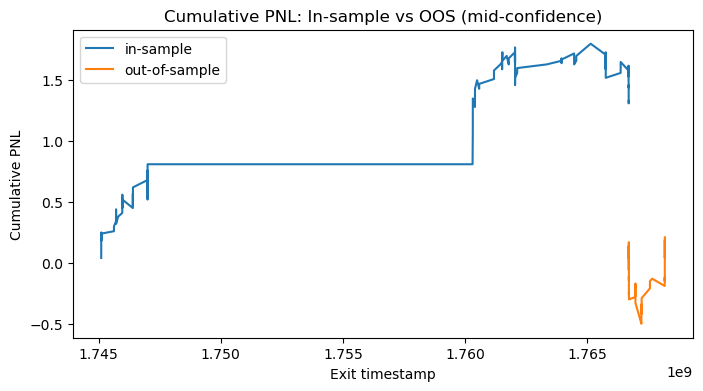

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if isinstance(trades, list):
    trades = pd.DataFrame(trades)

if trades.empty:
    print("No trades available.")
else:
    def first_valid_median(series: pd.Series) -> float:
        vals = series.dropna().head(5)
        if vals.empty:
            return np.nan
        return float(vals.median())

    p_open = (
        df.groupby("market_id", sort=False)["p_filled"]
        .apply(first_valid_median)
    )

    trades = trades.copy()
    trades["p_open"] = trades["market_id"].map(p_open)
    trades["confidence"] = (trades["p_open"] - 0.5).abs()

    filtered = trades[(trades["confidence"] >= 0.15) & (trades["confidence"] < 0.30)]

    if filtered.empty:
        print("No trades in mid-confidence bucket (0.15 <= |p_open-0.5| < 0.30).")
    else:
        filtered = filtered.sort_values("entry_ts").reset_index(drop=True)
        cut_idx = int(len(filtered) * 0.7)
        in_sample = filtered.iloc[:cut_idx].copy()
        out_sample = filtered.iloc[cut_idx:].copy()

        def summarize(df: pd.DataFrame, label: str) -> dict:
            if df.empty:
                return {
                    "split": label,
                    "num_trades": 0,
                    "win_rate": 0.0,
                    "mean_pnl": np.nan,
                    "median_pnl": np.nan,
                    "total_pnl": 0.0,
                    "max_drawdown": np.nan,
                }
            temp = df.sort_values("exit_ts").copy()
            temp["cum_pnl"] = temp["pnl"].cumsum()
            temp["cum_max"] = temp["cum_pnl"].cummax()
            temp["drawdown"] = temp["cum_pnl"] - temp["cum_max"]
            return {
                "split": label,
                "num_trades": len(temp),
                "win_rate": (temp["pnl"] > 0).mean(),
                "mean_pnl": temp["pnl"].mean(),
                "median_pnl": temp["pnl"].median(),
                "total_pnl": temp["pnl"].sum(),
                "max_drawdown": temp["drawdown"].min(),
            }

        summary = pd.DataFrame(
            [summarize(in_sample, "in_sample"), summarize(out_sample, "out_sample")]
        )
        print("Mid-confidence OOS split (0.15 <= |p_open-0.5| < 0.30)")
        print(summary)

        plt.figure(figsize=(8, 4))
        plt.plot(in_sample["exit_ts"], in_sample["pnl"].cumsum(), label="in-sample")
        plt.plot(out_sample["exit_ts"], out_sample["pnl"].cumsum(), label="out-of-sample")
        plt.title("Cumulative PNL: In-sample vs OOS (mid-confidence)")
        plt.xlabel("Exit timestamp")
        plt.ylabel("Cumulative PNL")
        plt.legend()
        plt.show()


Mid-confidence OOS split (0.15 <= |p_open-0.5| < 0.30)
        split  num_trades  win_rate  mean_pnl  median_pnl  total_pnl  \
0   in_sample         122  0.704918  0.010902        0.03       1.33   
1  out_sample          53  0.660377  0.003962        0.02       0.21   

   max_drawdown  
0         -0.49  
1         -0.67  


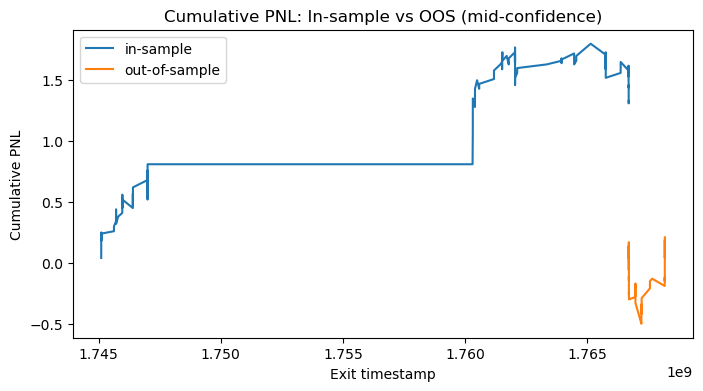

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if isinstance(trades, list):
    trades = pd.DataFrame(trades)

if trades.empty:
    print("No trades available.")
else:
    def first_valid_median(series: pd.Series) -> float:
        vals = series.dropna().head(5)
        if vals.empty:
            return np.nan
        return float(vals.median())

    p_open = (
        df.groupby("market_id", sort=False)["p_filled"]
        .apply(first_valid_median)
    )

    trades = trades.copy()
    trades["p_open"] = trades["market_id"].map(p_open)
    trades["confidence"] = (trades["p_open"] - 0.5).abs()

    filtered = trades[(trades["confidence"] >= 0.15) & (trades["confidence"] < 0.30)]

    if filtered.empty:
        print("No trades in mid-confidence bucket (0.15 <= |p_open-0.5| < 0.30).")
    else:
        filtered = filtered.sort_values("entry_ts").reset_index(drop=True)
        cut_idx = int(len(filtered) * 0.7)
        in_sample = filtered.iloc[:cut_idx].copy()
        out_sample = filtered.iloc[cut_idx:].copy()

        def summarize(df: pd.DataFrame, label: str) -> dict:
            if df.empty:
                return {
                    "split": label,
                    "num_trades": 0,
                    "win_rate": 0.0,
                    "mean_pnl": np.nan,
                    "median_pnl": np.nan,
                    "total_pnl": 0.0,
                    "max_drawdown": np.nan,
                }
            temp = df.sort_values("exit_ts").copy()
            temp["cum_pnl"] = temp["pnl"].cumsum()
            temp["cum_max"] = temp["cum_pnl"].cummax()
            temp["drawdown"] = temp["cum_pnl"] - temp["cum_max"]
            return {
                "split": label,
                "num_trades": len(temp),
                "win_rate": (temp["pnl"] > 0).mean(),
                "mean_pnl": temp["pnl"].mean(),
                "median_pnl": temp["pnl"].median(),
                "total_pnl": temp["pnl"].sum(),
                "max_drawdown": temp["drawdown"].min(),
            }

        summary = pd.DataFrame(
            [summarize(in_sample, "in_sample"), summarize(out_sample, "out_sample")]
        )
        print("Mid-confidence OOS split (0.15 <= |p_open-0.5| < 0.30)")
        print(summary)

        plt.figure(figsize=(8, 4))
        plt.plot(in_sample["exit_ts"], in_sample["pnl"].cumsum(), label="in-sample")
        plt.plot(out_sample["exit_ts"], out_sample["pnl"].cumsum(), label="out-of-sample")
        plt.title("Cumulative PNL: In-sample vs OOS (mid-confidence)")
        plt.xlabel("Exit timestamp")
        plt.ylabel("Cumulative PNL")
        plt.legend()
        plt.show()


In [36]:
import numpy as np

import pandas as pd



trades = pd.read_csv('data/trades_latest.csv', parse_dates=['entry_ts','exit_ts'])



if trades.empty:

    print('No trades in trades_latest.csv; check strategy settings.')

else:

    def _metrics(t):

        if t.empty:

            return {

                'num_trades': 0,

                'win_rate': np.nan,

                'mean_pnl': np.nan,

                'median_pnl': np.nan,

                'total_pnl': 0.0,

                'max_drawdown': np.nan,

            }

        t = t.sort_values('exit_ts')

        cum = t['pnl'].cumsum()

        dd = cum - cum.cummax()

        return {

            'num_trades': int(len(t)),

            'win_rate': (t['pnl'] > 0).mean(),

            'mean_pnl': t['pnl'].mean(),

            'median_pnl': t['pnl'].median(),

            'total_pnl': t['pnl'].sum(),

            'max_drawdown': dd.min(),

        }



    baseline = trades.copy()

    baseline_n = len(baseline)



    vol10_q = baseline['vol_10_e'].quantile([0.90, 0.92, 0.95])

    volsum_q = baseline['vol_sum_5_e'].quantile([0.90, 0.92, 0.95])



    filters = {

        'A_move>=0.07': baseline['move_from_base'] >= 0.07,

        'A_move>=0.09': baseline['move_from_base'] >= 0.09,

        'A_move>=0.11': baseline['move_from_base'] >= 0.11,

        'B_vol10>=q90': baseline['vol_10_e'] >= vol10_q.loc[0.90],

        'B_vol10>=q92': baseline['vol_10_e'] >= vol10_q.loc[0.92],

        'B_vol10>=q95': baseline['vol_10_e'] >= vol10_q.loc[0.95],

        'C_volsum>=q90': baseline['vol_sum_5_e'] >= volsum_q.loc[0.90],

        'C_volsum>=q92': baseline['vol_sum_5_e'] >= volsum_q.loc[0.92],

        'C_volsum>=q95': baseline['vol_sum_5_e'] >= volsum_q.loc[0.95],

    }



    results = []

    for name, mask in filters.items():

        t = baseline[mask].copy()

        m = _metrics(t)

        m['variant'] = name

        m['retained_pct'] = (m['num_trades'] / baseline_n) if baseline_n else np.nan

        results.append(m)



    results_df = pd.DataFrame(results).sort_values('total_pnl', ascending=False)

    display(results_df)



    best_mean = results_df.loc[results_df['mean_pnl'].idxmax()]

    best_total = results_df.loc[results_df['total_pnl'].idxmax()]

    pos_total = results_df[results_df['total_pnl'] > 0]

    best_dd = pos_total.loc[pos_total['max_drawdown'].idxmax()] if not pos_total.empty else None



    print('\nBest by mean_pnl:', best_mean['variant'])

    print('Best by total_pnl:', best_total['variant'])

    if best_dd is not None:

        print('Best by max_drawdown (least negative) with positive total_pnl:', best_dd['variant'])

    else:

        print('No variants with positive total_pnl for max_drawdown selection.')



EmptyDataError: No columns to parse from file

In [42]:
import numpy as np
from pathlib import Path

import pandas as pd

from pandas.errors import EmptyDataError



try:

    trades = pd.read_csv('data/trades_latest.csv', parse_dates=['entry_ts','exit_ts'])

except EmptyDataError:

    trades = pd.DataFrame()



if trades.empty:

    print('No trades in trades_latest.csv; run the latest strategy script first.')

else:

    def _metrics(t):

        if t.empty:

            return {

                'num_trades': 0,

                'win_rate': np.nan,

                'mean_pnl': np.nan,

                'median_pnl': np.nan,

                'total_pnl': 0.0,

                'max_drawdown': np.nan,

            }

        t = t.sort_values('exit_ts')

        cum = t['pnl'].cumsum()

        dd = cum - cum.cummax()

        return {

            'num_trades': int(len(t)),

            'win_rate': (t['pnl'] > 0).mean(),

            'mean_pnl': t['pnl'].mean(),

            'median_pnl': t['pnl'].median(),

            'total_pnl': t['pnl'].sum(),

            'max_drawdown': dd.min(),

        }



    baseline = trades.copy()

    baseline_n = len(baseline)



    vol10_q = baseline['vol_10_e'].quantile([0.90, 0.92, 0.95])

    volsum_q = baseline['vol_sum_5_e'].quantile([0.90, 0.92, 0.95])



    filters = {

        'A_move>=0.07': baseline['move_from_base'] >= 0.07,

        'A_move>=0.09': baseline['move_from_base'] >= 0.09,

        'A_move>=0.11': baseline['move_from_base'] >= 0.11,

        'B_vol10>=q90': baseline['vol_10_e'] >= vol10_q.loc[0.90],

        'B_vol10>=q92': baseline['vol_10_e'] >= vol10_q.loc[0.92],

        'B_vol10>=q95': baseline['vol_10_e'] >= vol10_q.loc[0.95],

        'C_volsum>=q90': baseline['vol_sum_5_e'] >= volsum_q.loc[0.90],

        'C_volsum>=q92': baseline['vol_sum_5_e'] >= volsum_q.loc[0.92],

        'C_volsum>=q95': baseline['vol_sum_5_e'] >= volsum_q.loc[0.95],

    }



    print(f"Baseline trades: {baseline_n}")



    results = []

    for name, mask in filters.items():

        t = baseline[mask].copy()

        m = _metrics(t)

        m['variant'] = name

        m['retained_pct'] = (m['num_trades'] / baseline_n) if baseline_n else np.nan

        m['filtered_out'] = baseline_n - m['num_trades'] if baseline_n else 0

        results.append(m)

        print(f"{name}: kept {m['num_trades']} / {baseline_n} (filtered_out={m['filtered_out']})")



    results_df = pd.DataFrame(results).sort_values('total_pnl', ascending=False)

    display(results_df)



    best_mean = results_df.loc[results_df['mean_pnl'].idxmax()]

    best_total = results_df.loc[results_df['total_pnl'].idxmax()]

    pos_total = results_df[results_df['total_pnl'] > 0]

    best_dd = pos_total.loc[pos_total['max_drawdown'].idxmax()] if not pos_total.empty else None



    print('\nBest by mean_pnl:', best_mean['variant'])

    print('Best by total_pnl:', best_total['variant'])

    if best_dd is not None:

        print('Best by max_drawdown (least negative) with positive total_pnl:', best_dd['variant'])

    else:

        print('No variants with positive total_pnl for max_drawdown selection.')



No trades in trades_latest.csv; run the latest strategy script first.
